# **ROAD DAMAGE DETECTION**


---


## **Exploratory Data Analysis**

---
**About the data:**

The dataset can be downloaded from [here](https://github.com/sekilab/RoadDamageDetector/).
The training dataset contains Japan/India/Czech images and annotations. The format of annotations is the same as pascal VOC. The dataset proposed in this study considers data collected from multiple countries- Japan, India and Czech Republic (partially from Slovakia).
1. The total number of images is increased to 26620, almost thrice the prevailing 2018 dataset.
2. New images were collected from India and Czech Republic (partially from Slovakia) to make the data more heterogeneous and train robust algorithms.
3. Although there are many types of road damage categories, the dataset focuses on following types:

* **D00:** Linear crack, longitudinal, wheel mark part
* **D10:**  Linear crack, lateral, equal interval
* **D20:** Alligator crack
* **D40:** Potholes, Rutting, Dump, Separation
* **D43:** Cross Walk Blur
* **D44:** White Line Blur
* **D50:** Utility hole (maintenance hatch)

refer: https://www.researchgate.net/publication/341836638_Generative_adversarial_network_for_road_damage_detection

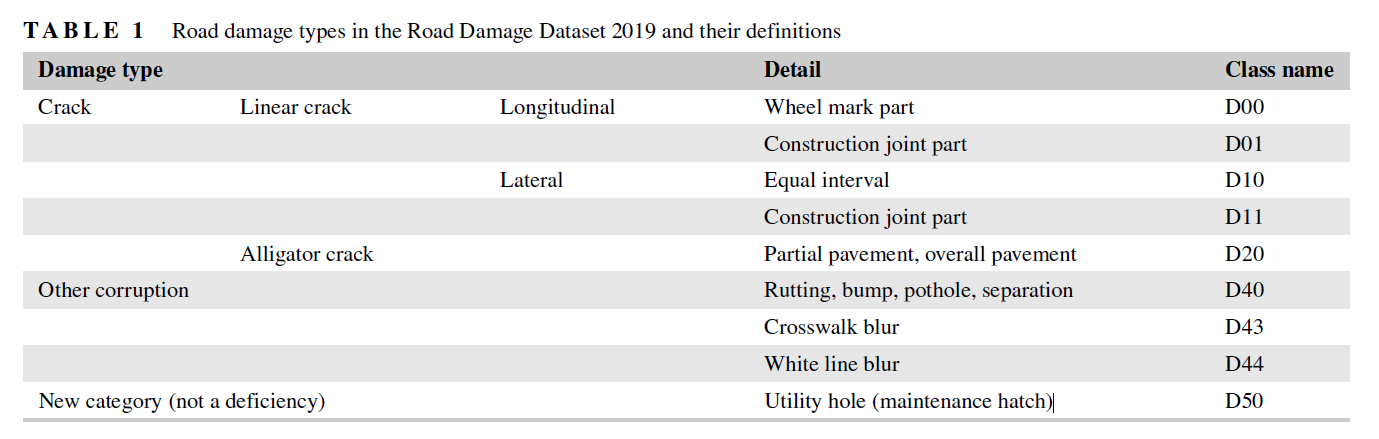

**Note:** The standards related to evaluations of Road Marking deterioration such as Crosswalk or White Line Blur differ significantly across several countries. Thus, these categories can be excluded from the study so that generalized models can be trained applicable for monitoring road conditions in more than one country. But we will see what happens when we include them.

Now, this dataset is in Pascal VOC format which is an XML file unlike coco dataset which is a JSON file.
For EDA I will convert them into coco format first, [refer](https://github.com/yukkyo/voc2coco).

In [1]:
!wget https://mycityreport.s3-ap-northeast-1.amazonaws.com/02_RoadDamageDataset/public_data/IEEE_bigdata_RDD2020/train.tar.gz

--2021-02-02 10:07:01--  https://mycityreport.s3-ap-northeast-1.amazonaws.com/02_RoadDamageDataset/public_data/IEEE_bigdata_RDD2020/train.tar.gz
Resolving mycityreport.s3-ap-northeast-1.amazonaws.com (mycityreport.s3-ap-northeast-1.amazonaws.com)... 52.219.0.179
Connecting to mycityreport.s3-ap-northeast-1.amazonaws.com (mycityreport.s3-ap-northeast-1.amazonaws.com)|52.219.0.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1472626254 (1.4G) [application/x-tar]
Saving to: ‘train.tar.gz’

train.tar.gz        100%[===================>]   1.37G  19.3MB/s    in 75s     

2021-02-02 10:08:17 (18.8 MB/s) - ‘train.tar.gz’ saved [1472626254/1472626254]



In [2]:
!tar -xf 'train.tar.gz'

In [3]:
!wget https://mycityreport.s3-ap-northeast-1.amazonaws.com/02_RoadDamageDataset/public_data/IEEE_bigdata_RDD2020/test1.tar.gz

--2021-02-02 10:10:02--  https://mycityreport.s3-ap-northeast-1.amazonaws.com/02_RoadDamageDataset/public_data/IEEE_bigdata_RDD2020/test1.tar.gz
Resolving mycityreport.s3-ap-northeast-1.amazonaws.com (mycityreport.s3-ap-northeast-1.amazonaws.com)... 52.219.8.86
Connecting to mycityreport.s3-ap-northeast-1.amazonaws.com (mycityreport.s3-ap-northeast-1.amazonaws.com)|52.219.8.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 186476694 (178M) [application/x-tar]
Saving to: ‘test1.tar.gz’

test1.tar.gz        100%[===================>] 177.84M  18.8MB/s    in 11s     

2021-02-02 10:10:13 (16.9 MB/s) - ‘test1.tar.gz’ saved [186476694/186476694]



In [4]:
!tar -xf 'test1.tar.gz'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import tensorflow as tf
from tensorflow.core.framework import graph_pb2 as gpb
from google.protobuf import text_format as pbtf

In [6]:
#https://stackoverflow.com/a/65891556
#this function reads the labels from label_map.pbtxt file:
def read_label_map(label_map_path):

    item_id = None
    item_name = None
    items = {}
    
    with open(label_map_path, "r") as file:
        for line in file:
            line.replace(" ", "")
            if line == "item{":
                pass
            elif line == "}":
                pass
            elif "id" in line:
                item_id = int(line.split(":", 1)[1].strip())
            elif "name" in line:
                item_name = line.split(":", 1)[1].replace("'", "").strip()

            if item_id is not None and item_name is not None:
                items[item_name] = item_id
                item_id = None
                item_name = None

    return items

print([i for i in read_label_map("train/label_map.pbtxt")])

['D00', 'D10', 'D20', 'D40']


In [7]:
#https://gist.github.com/rotemtam/88d9a4efae243fc77ed4a0f9917c8f6c
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            bbx = member.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = member.find('name').text

            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main():

    country = ['Czech', 'India', 'Japan']
    for cn in country:
        
      image_path = os.path.join('train', cn,'annotations','xmls')
      xml_df = xml_to_csv(image_path)
      xml_df.to_csv('labels_{}.csv'.format(cn), index=None)
      print('Successfully converted xml to csv.')


main()

Successfully converted xml to csv.
Successfully converted xml to csv.
Successfully converted xml to csv.


In [8]:
df_czech = pd.read_csv('labels_Czech.csv')
df_czech.head()

filename  width  height class  xmin  ymin  xmax  ymax
0  Czech_003453.jpg      3     600   D00   235   405   257   506
1  Czech_001962.jpg      3     600   D10     7   447   106   466
2  Czech_000780.jpg      3     600   D00   282   400   321   476
3  Czech_001054.jpg      3     600   D10     3   431    96   447
4  Czech_001054.jpg      3     600   D40   351   457   408   510

In [9]:
df_czech.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1745 entries, 0 to 1744
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1745 non-null   object
 1   width     1745 non-null   int64 
 2   height    1745 non-null   int64 
 3   class     1745 non-null   object
 4   xmin      1745 non-null   int64 
 5   ymin      1745 non-null   int64 
 6   xmax      1745 non-null   int64 
 7   ymax      1745 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 109.2+ KB


In [10]:
df_czech = pd.read_csv('labels_Czech.csv')
df_India = pd.read_csv('labels_India.csv')
df_Japan = pd.read_csv('labels_Japan.csv')

In [11]:
df = pd.concat([df_czech, df_India, df_Japan])
df.head()

filename  width  height class  xmin  ymin  xmax  ymax
0  Czech_003453.jpg      3     600   D00   235   405   257   506
1  Czech_001962.jpg      3     600   D10     7   447   106   466
2  Czech_000780.jpg      3     600   D00   282   400   321   476
3  Czech_001054.jpg      3     600   D10     3   431    96   447
4  Czech_001054.jpg      3     600   D40   351   457   408   510

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34702 entries, 0 to 24753
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  34702 non-null  object
 1   width     34702 non-null  int64 
 2   height    34702 non-null  int64 
 3   class     34702 non-null  object
 4   xmin      34702 non-null  int64 
 5   ymin      34702 non-null  int64 
 6   xmax      34702 non-null  int64 
 7   ymax      34702 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 2.4+ MB


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns


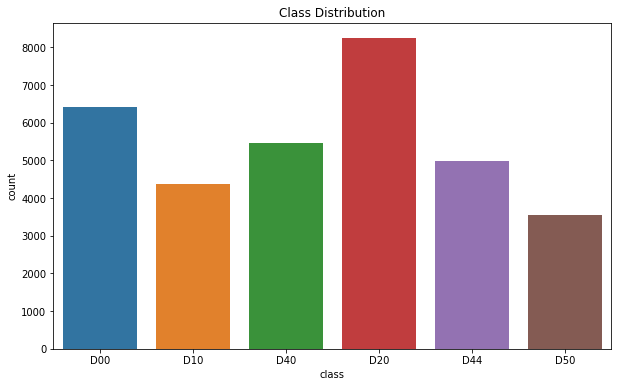

In [121]:
plt.figure(figsize=(10,6))
sns.countplot(x = df['class'])
plt.title('Class Distribution')
plt.show()

In [15]:
df['class'].value_counts()

D20     8381
D00     6592
D40     5627
D44     5057
D10     4446
D50     3581
D43      793
D01      179
D11       45
D0w0       1
Name: class, dtype: int64

### **Observation:**
* There can be seen 10 different classes of damages as mentioned in the begining.
* The data is not balanced as class D43 (Cross Walk Blur), D01 (Longitudinal Construction Joint Part Crack), D11 (Lateral Construction Joint Part Crack) and D0w0 is really scarce whereas D20 (Alligator Crack) is in abundance.
* So we may think of dropping all the entries with D43, D01, D11 and D0w0.



In [16]:
#dropping NaN values.
df = df.dropna()

In [17]:
# dropping entries with D0w0, D11, D01 and D43 type road damage:
df.drop(df[df['class'] == 'D0w0'].index, inplace = True) 
df.drop(df[df['class'] == 'D11'].index, inplace = True) 
df.drop(df[df['class'] == 'D01'].index, inplace = True) 
df.drop(df[df['class'] == 'D43'].index, inplace = True) 

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33024 entries, 0 to 24753
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  33024 non-null  object
 1   width     33024 non-null  int64 
 2   height    33024 non-null  int64 
 3   class     33024 non-null  object
 4   xmin      33024 non-null  int64 
 5   ymin      33024 non-null  int64 
 6   xmax      33024 non-null  int64 
 7   ymax      33024 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 2.3+ MB


### **Now let's save the file names:**

In [19]:
f = open('train_ext.txt','w') 
for name in df['filename'].values:
  f.write(name)
  f.write('\n')
f.close()


In [20]:
f= open('train_ext.txt','r') 
#print(f.read())

f.close()

In [21]:
f = open('train_no_ext.txt','w') 
with open('train_ext.txt','r') as file:
  name = file.read()
  name = name.replace(".","")
  name = name.replace("jpg","")
  name = name.replace("JPG","")
  f.write(name)
f.close()


In [22]:
f= open('train_no_ext.txt','r') 
#print(f.read())

f.close()

In [23]:
import os
import argparse
import json
import xml.etree.ElementTree as ET
from typing import Dict, List
from tqdm import tqdm
import re

In [41]:
df.shape[0]

33078

In [24]:
# creating a column with area covered by that bouding box of image:

df['area'] = (df['xmax'] - df['xmin'])*(df['ymax']-df['ymin'])
df.head()

filename  width  height class  xmin  ymin  xmax  ymax  area
0  Czech_003453.jpg      3     600   D00   235   405   257   506  2222
1  Czech_001962.jpg      3     600   D10     7   447   106   466  1881
2  Czech_000780.jpg      3     600   D00   282   400   321   476  2964
3  Czech_001054.jpg      3     600   D10     3   431    96   447  1488
4  Czech_001054.jpg      3     600   D40   351   457   408   510  3021

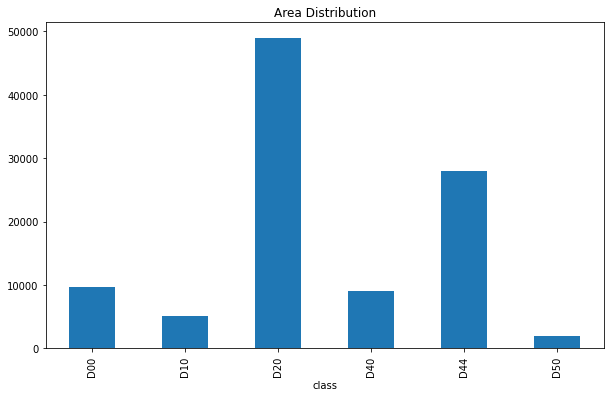

In [120]:
plt.figure(figsize=(10,6))
df.groupby('class').mean()['area'].plot.bar()
plt.title('Area Distribution')
plt.show()

## **Observation:**
* This plot tells us about the average area covered by the bounding box.
* Clearly we can see D20 (Aligator Crack) has the highest mean area.
* D50 (Utility Hole) has the smalled average area.
* This tells us that Aligator cracks are usually spread on more area of road followed by D44 (White line blur).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

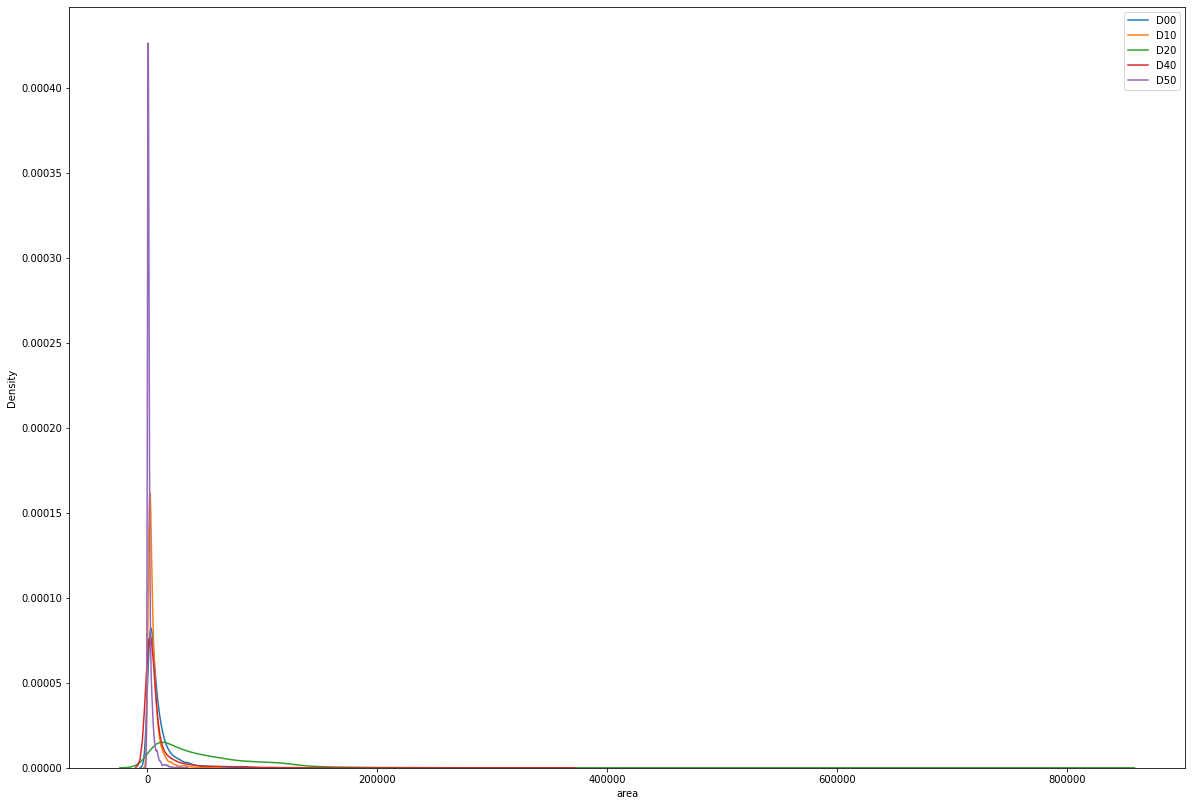

In [26]:

plt.figure(figsize=(20,14))
sns.distplot(df[df['class']=='D00']['area'], hist=False, label="D00")
sns.distplot(df[df['class']=='D10']['area'], hist=False, label="D10")
sns.distplot(df[df['class']=='D20']['area'], hist=False, label="D20")
sns.distplot(df[df['class']=='D40']['area'], hist=False, label="D40")
sns.distplot(df[df['class']=='D50']['area'], hist=False, label="D50")

plt.legend()
plt.show()

## **Observation:**
* Most of the damage classes have very small spread or variance.
* Though the green one, D20 (Aligator crack), has a wride spread.
* Wide spread signifies that the damage is propagated more on the road rather than being concentrated at a single small point.

In [115]:
import os
import numpy as np
import argparse
import random
import cv2
from google.colab.patches import cv2_imshow

def process_image(country,image_name):
    #this function takes an image and prints it as both raw and with bounding boxes:
    
    image_path = os.path.join('train', country,'images',image_name)
    image = cv2.imread(image_path)
    #cv2_imshow(image)
    image1 = cv2.putText(image,image_name,(50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    #cv2_imshow(image)
    box_color = (0, 255, 0)  #Green
    start_point = (df[df['filename']== image_name]['xmin'].iloc[[0]].values[0], df[df['filename']== image_name]['ymin'].iloc[[0]].values[0])
    end_point =  (df[df['filename']== image_name]['xmax'].iloc[[0]].values[0], df[df['filename']== image_name]['ymax'].iloc[[0]].values[0])
    #print(start_point)
    #print(end_point)
    image2 = np.array(image1)
    image2 = cv2.UMat(image2).get()
    image2 = cv2.rectangle(np.array(image2), start_point , end_point, box_color,2)
    
    image2 = cv2.putText(image2, df[df['filename']== image_name]['class'].iloc[[0]].values[0], start_point, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    return cv2_imshow(cv2.hconcat((image1, image2)))

# **Japan Images**

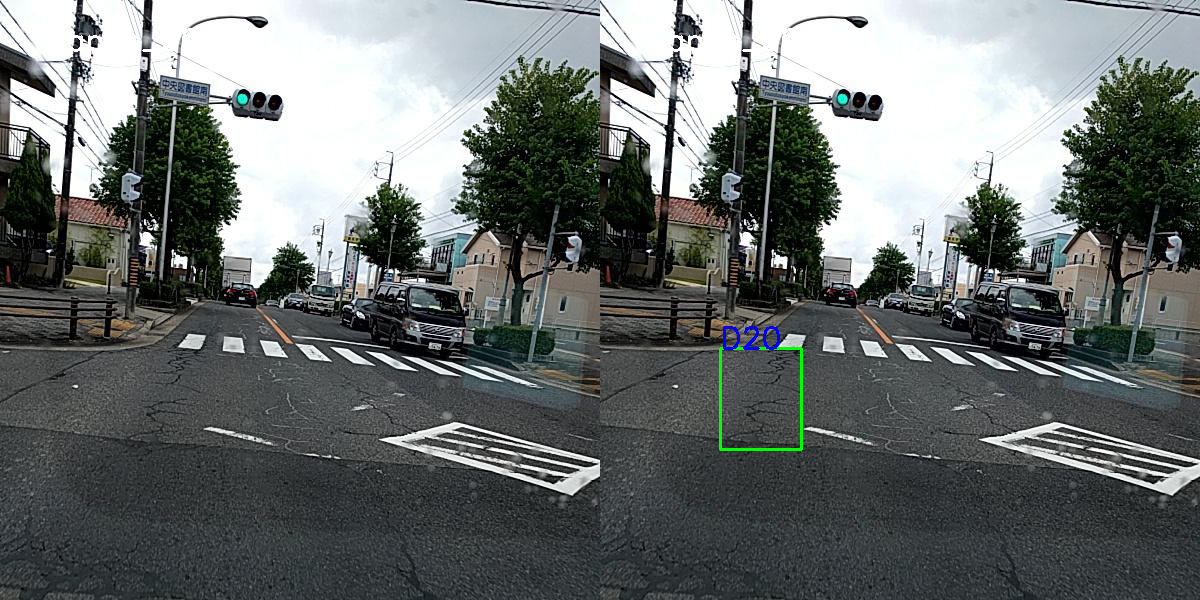

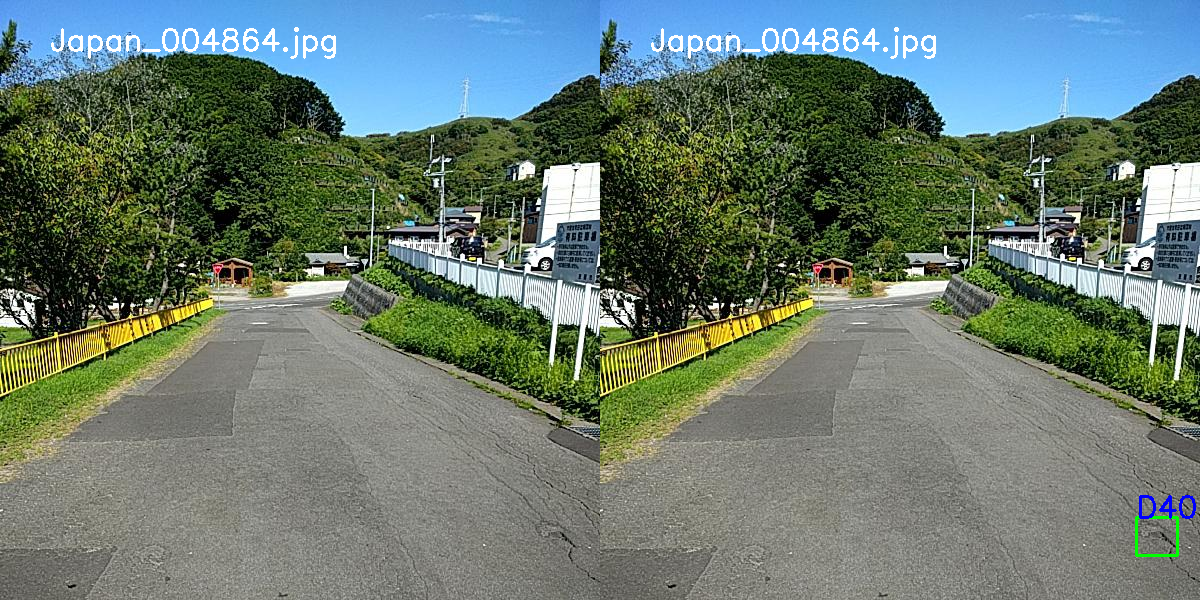

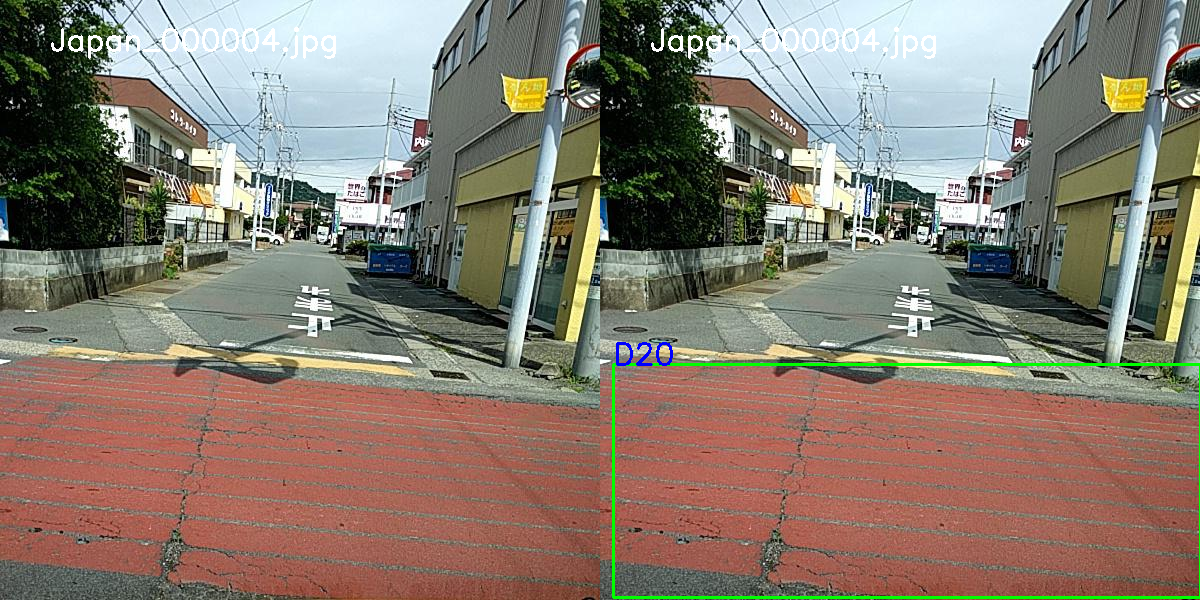

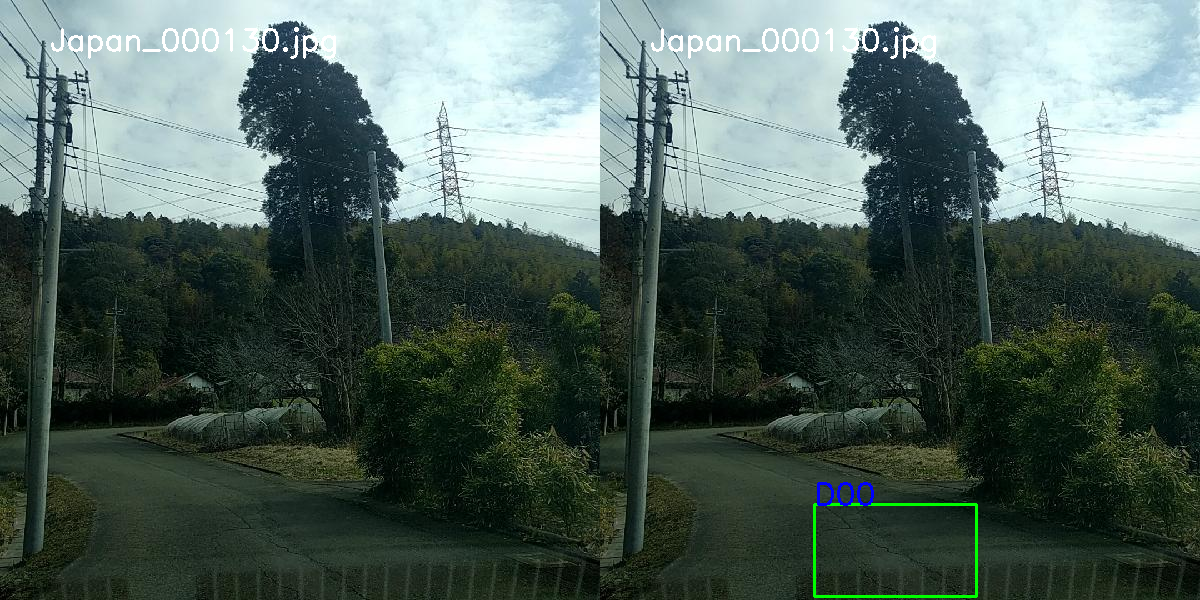

In [116]:
japan_names = ['Japan_001111.jpg','Japan_004864.jpg', 'Japan_000004.jpg','Japan_000130.jpg' ]
for img in japan_names:
  process_image('Japan',img)

# **India Images**

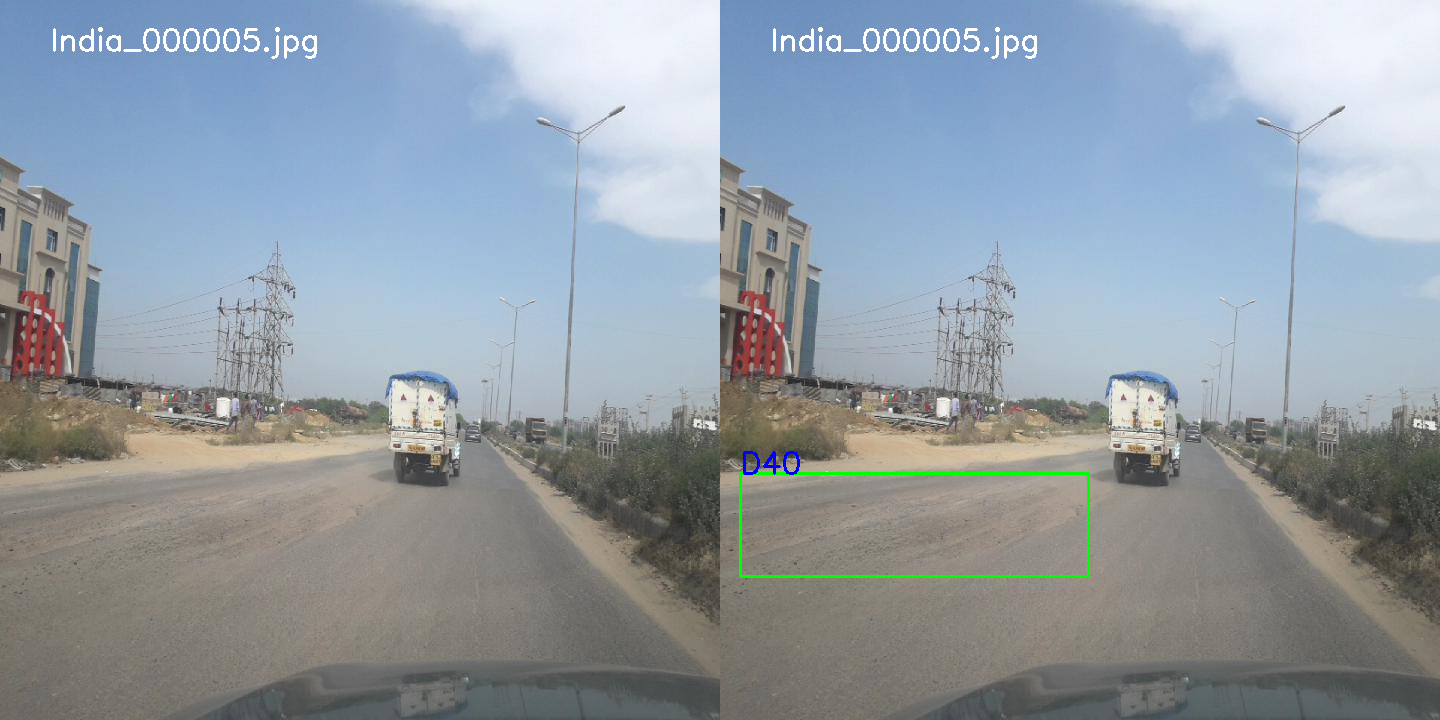

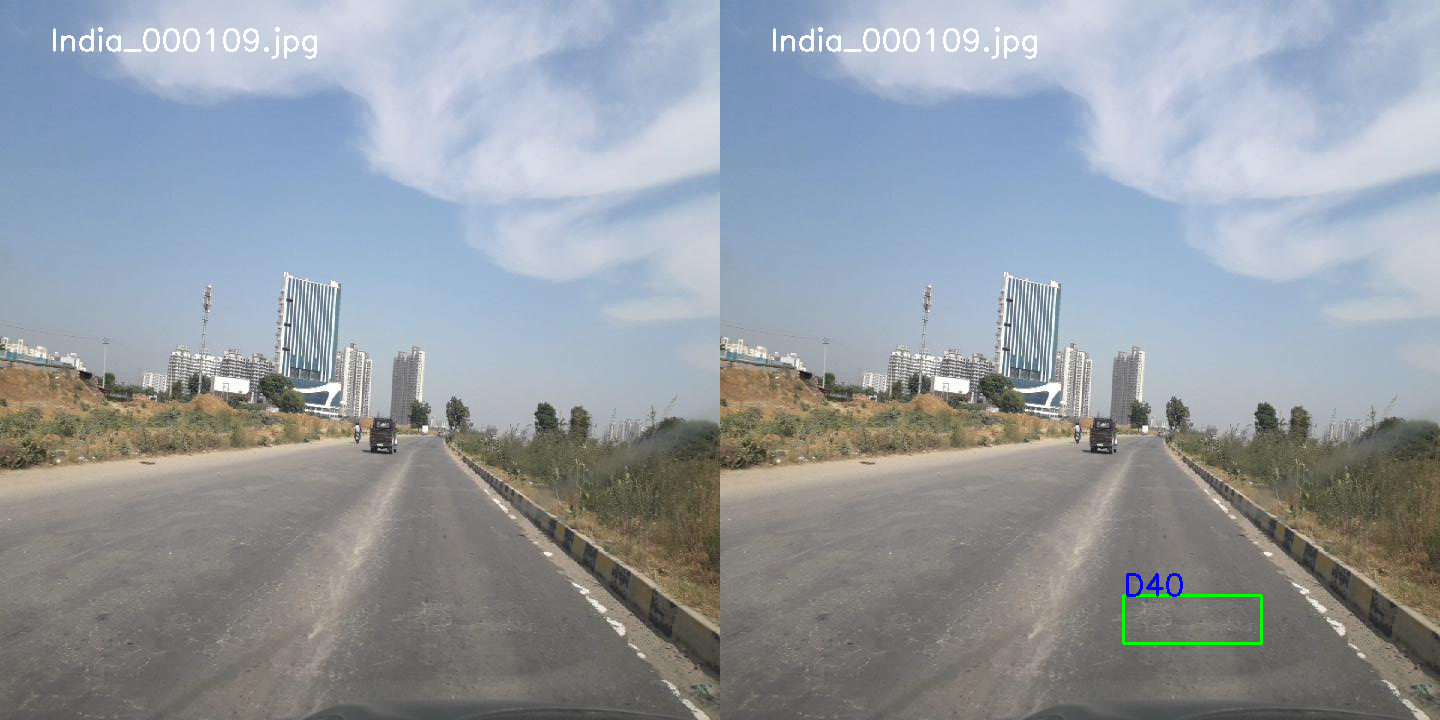

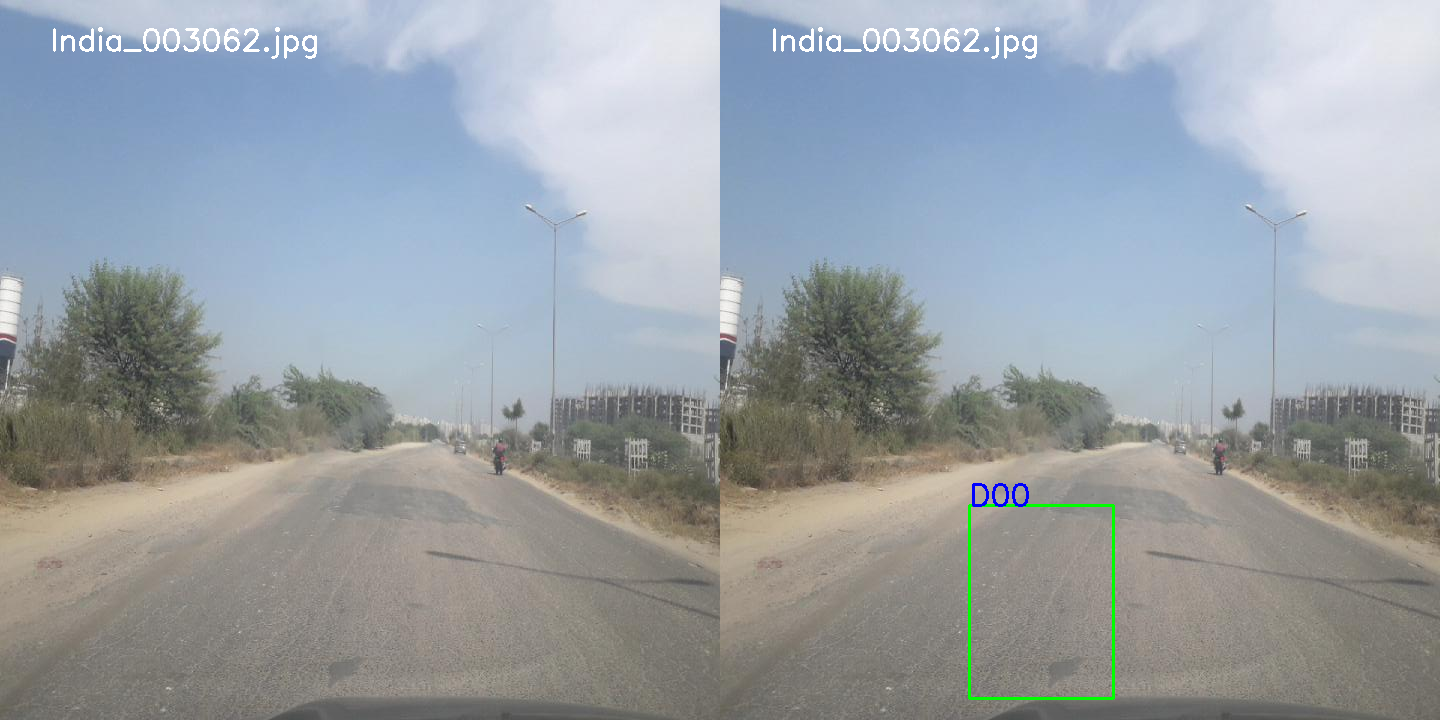

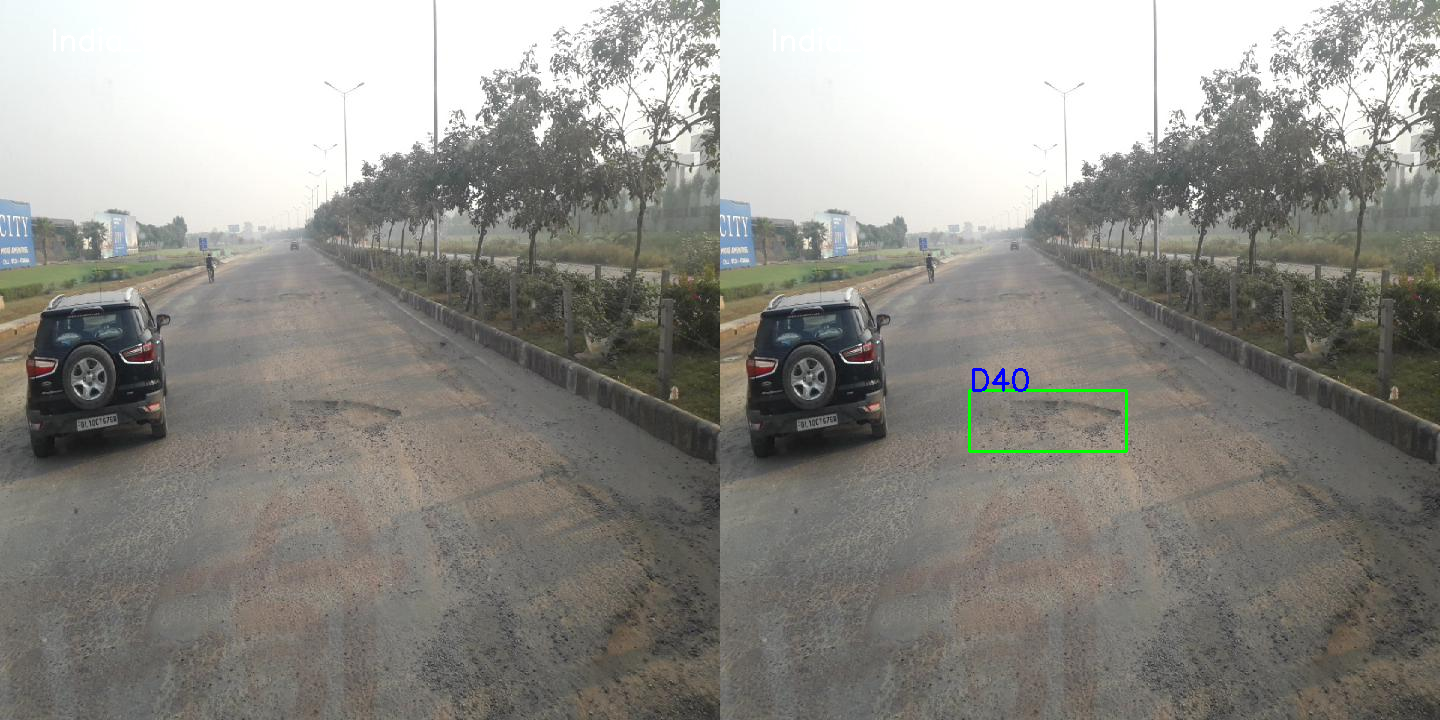

In [117]:
India_names = ['India_000005.jpg','India_000109.jpg', 'India_003062.jpg','India_009268.jpg' ]
for img in India_names:
  process_image('India',img)

# **Czech Images**

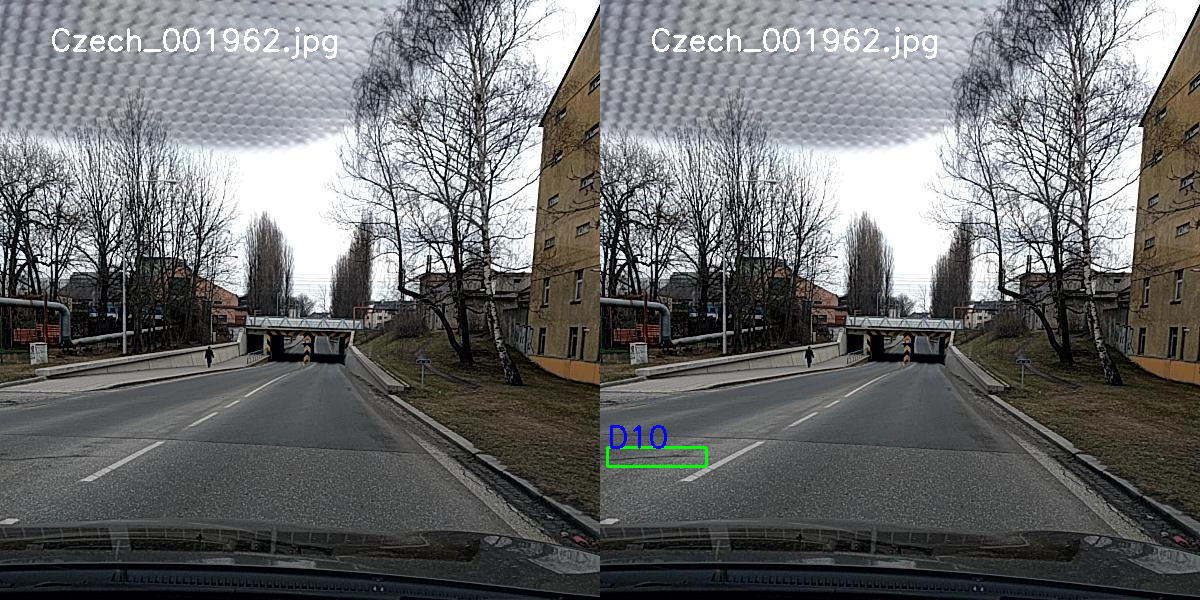

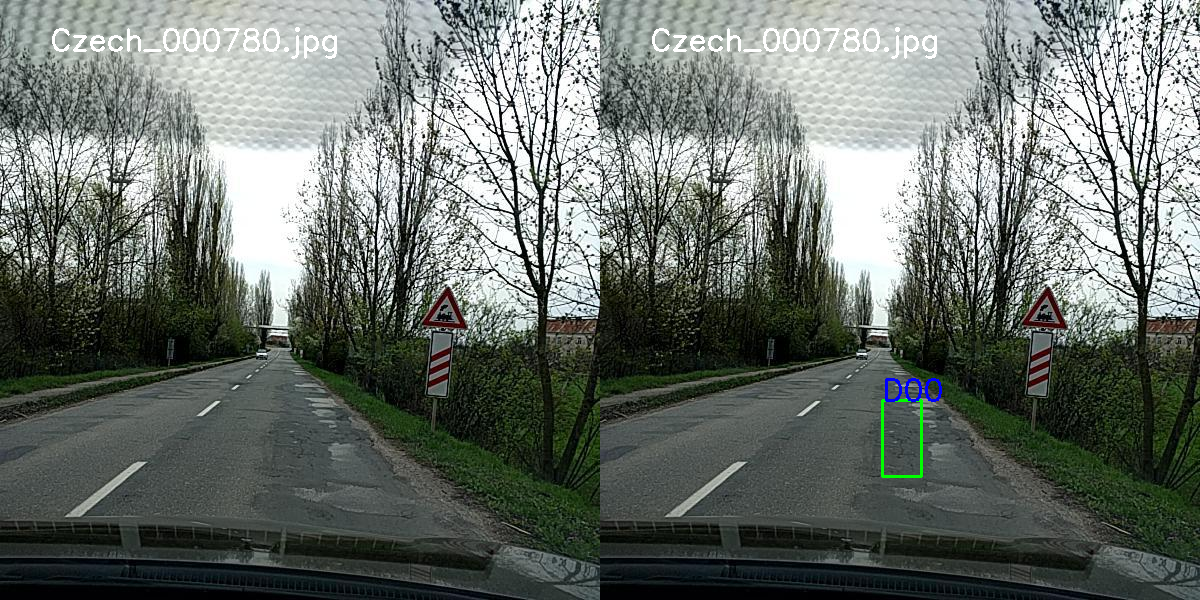

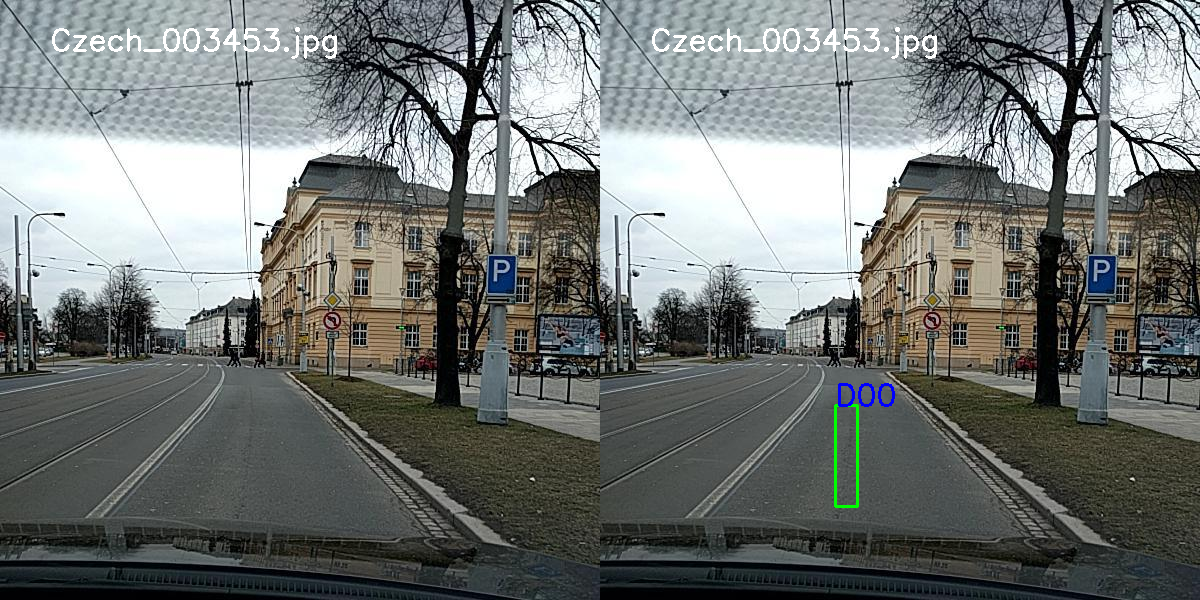

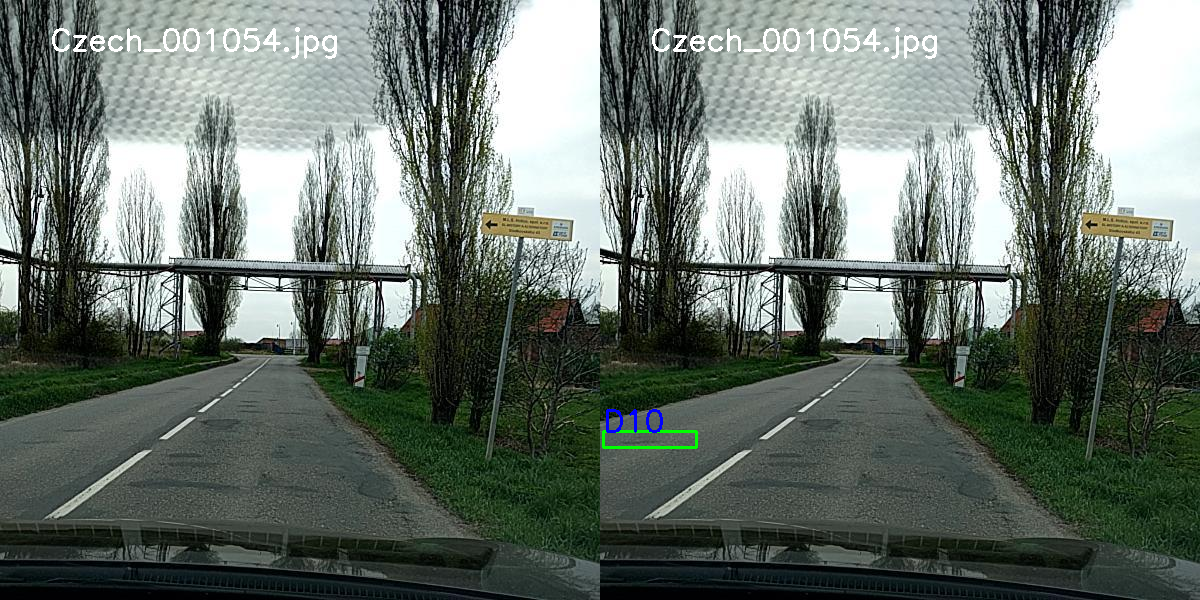

In [118]:
zech_names = ['Czech_001962.jpg','Czech_000780.jpg', 'Czech_003453.jpg','Czech_001054.jpg' ]
for img in zech_names:
  process_image('Czech',img)